In [1]:
import pickle
import numpy as np

def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    data = x.load()
    return data                                 #creating seperate file path for each 32 participantes

files = []
for n in range(1, 33):
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)


['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']


In [2]:
labels = []
data = []
for i in files:
    fileph = "data_preprocessed_python/s" + i + ".dat"
    d = read_data(fileph)
    labels.append(d['labels'])
    data.append(d['data'])
print(len(labels))                             #creating seperate list for label and data
print(len(data))


32
32


In [3]:
labels = np.array(labels)
data = np.array(data)
print(labels.shape)      # 40 trials,4 emotion dimensions
print(data.shape)        #40 trials,40 channels,8064 data points

labels = labels.reshape(1280, 4)         #32 X 4 1280 trials, 4 emotion dimensions
data = data.reshape(1280, 40, 8064)      #32 X 4 1280 trials,40 channels,8064 data points
print(labels.shape)
print(data.shape)

eeg_data = data[:,:32,:]                #extracting 32 EEG channels out of total 40 channels
print(eeg_data.shape)


(32, 40, 4)
(32, 40, 40, 8064)
(1280, 4)
(1280, 40, 8064)
(1280, 32, 8064)


In [4]:
import pandas as pd
df_label = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1],
                        'Dominance': labels[:,2], 'Liking': labels[:,3]})     #converting it label to dataframes for the simplification
df_label

,Valence,Arousal,Dominance,Liking
0,7.71,7.60,6.90,7.83
1,8.10,7.31,7.28,8.47
2,8.58,7.54,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
...,...,...,...,...
1275,3.91,6.96,5.82,3.12
1276,2.81,6.13,6.06,1.04
1277,3.05,7.01,5.10,1.10
1278,3.99,7.17,4.85,1.00


In [5]:
label_name = ["valence", "arousal", "dominance", "liking"]
labels_valence = []
labels_arousal = []
labels_dominance = []
labels_liking = []

for la in labels:                                       #creating seperate list for each emotion dimension
    if la[0] > 5:                                       #Conversion of each emotion dimension to binary value
        labels_valence.append(1)                        
    else:
        labels_valence.append(0)
    
    if la[1] > 5:
        labels_arousal.append(1)
    else:
        labels_arousal.append(0)
    
    if la[2] > 5:
        labels_dominance.append(1)
    else:
        labels_dominance.append(0)
    
    if la[3] > 6:
        labels_liking.append(1)
    else:
        labels_liking.append(0)


In [6]:
df_label_bin = pd.DataFrame({'Valence': labels_valence, 'Arousal': labels_arousal, 
                            'Dominance': labels_dominance, 'Liking': labels_liking})  #creating dataframes for simplification
df_label_bin

,Valence,Arousal,Dominance,Liking
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,0,1,1,1
4,1,0,1,1
...,...,...,...,...
1275,0,1,1,0
1276,0,1,1,0
1277,0,1,1,0
1278,0,1,0,0


In [7]:
data_downsampled = eeg_data[:, :, ::4]  # Downsample by a factor of 4
print(data_downsampled.shape)           #takes the 4'th data point by preserving the key features

(1280, 32, 2016)


In [8]:
data_baseline_removed = data_downsampled - np.mean(data_downsampled, axis=2, keepdims=True)
print(data_baseline_removed.shape)         #baseline removal by subtracting mean of each channel for every trial which ensures that only variations in siganl are considerd improves SNR

(1280, 32, 2016)


In [9]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=-1)
    return y

# Apply bandpass filter                                                      #bandpass filtering only relevant frequency are considers from 4-45(alpha,beta,gamma)
fs = 128  # Sampling rate (Hz)
lowcut = 4  # Lower bound of bandpass filter (Hz)
highcut = 45  # Upper bound of bandpass filter (Hz)

data_filtered = bandpass_filter(data_baseline_removed, lowcut, highcut, fs)
print(data_filtered.shape)


(1280, 32, 2016)


In [10]:
data_CAR = data_filtered - np.mean(data_filtered, axis=1, keepdims=True)
print(data_CAR.shape)                       #common avg referencing removes common noise among all the channels
  

(1280, 32, 2016)


In [11]:
num_trials = 40
trial_data = np.array_split(data_CAR, num_trials, axis=0)
print(len(trial_data))
print(trial_data[0].shape)

40
(32, 32, 2016)


In [12]:
import math

def differential_entropy(data):
    return 0.5 * np.log2(2 * math.pi * math.e * np.var(data, axis=-1))
                                        #DE computed as logarithmic of signal variance widely use to classify emotional states accurately
# Extract DE features
DE_features = differential_entropy(data_CAR)
print(DE_features.shape)


(1280, 32)


In [13]:
pip install scipy==1.13.1

Note: you may need to restart the kernel to use updated packages.


In [14]:
import scipy
from scipy.signal import welch
from scipy.integrate import simps

def bandpower(data, sf, band):
    band = np.asarray(band)
    low, high = band
    nperseg = (2 / low) * sf
    freqs, psd = welch(data, sf, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = simps(psd[idx_band], dx=freq_res)
    return bp
def get_band_power(people, channel, band):
    bd = (0,0)
    if (band == "delta"):
        bd = (0.5,4)                              #calculates band power for different frequency ranges.
    if (band == "theta"):
        bd = (4,8)
    elif (band == "alpha"):
        bd = (8,12)
    elif (band == "beta"):
        bd = (12,30)
    elif (band == "gamma"):
        bd = (30,64)
    return bandpower(eeg_data[people,channel], 128, bd)

In [15]:
eeg_band = []
for i in range (len(eeg_data)):
    for j in range (len(eeg_data[0])):
        eeg_band.append(get_band_power(i,j,"delta"))   #extract band power in delta frequency for all the individuals and channels because delta wave provides crucial info about 
                                                       #brain activity and provides wide range of brain signal.
        eeg_band.append(get_band_power(i,j,"theta"))
        eeg_band.append(get_band_power(i,j,"alpha"))
        eeg_band.append(get_band_power(i,j,"beta"))
        eeg_band.append(get_band_power(i,j,"gamma"))

/var/folders/4v/m7_zmbx51q1821mk6jcl41v40000gn/T/ipykernel_85381/2321714312.py:12: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  bp = simps(psd[idx_band], dx=freq_res)


In [16]:
eeg_band = np.array(eeg_band)
eeg_band = eeg_band.reshape((1280,160)) 
print(eeg_band.shape)
np.save("eeg_band.npy", eeg_band)
eeg_band = np.load("eeg_band.npy")
print(eeg_band.shape)


(1280, 160)
(1280, 160)


In [17]:
data_x = eeg_band
print(data_x.shape)
label_y = labels_arousal
trainscores = []
testscores = []
X = data_x                                                 #preprocessing
from sklearn import preprocessing                          #feature_expansion- Capture non-linear relationships.
poly = preprocessing.PolynomialFeatures(degree=2)          #scaling
X = poly.fit_transform(X)                                  #normalization  -Ensures all features are on the same scale and normalized for better classifier performance.
min_max_scaler = preprocessing.MinMaxScaler()              #PCA: Reduces the dimensionality to 1000 components, speeding up training while retaining important variance.
X=min_max_scaler.fit_transform(X)
X = preprocessing.normalize(X, norm='l1')
print(X.shape)
from sklearn.decomposition import PCA
pca = PCA(n_components=1000)
X=pca.fit_transform(X)
print(X.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, label_y)   #TRAIN-TEST SPLIT


(1280, 160)
(1280, 13041)
(1280, 1000)


In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train,)
train_score=knn.score(X_train,y_train)
test_score=knn.score(X_test,y_test)
print("train_score：", train_score)
print("test_score：", test_score)
trainscores.append(train_score)
testscores.append(test_score)

train_score： 0.7104166666666667
test_score： 0.6125


In [19]:
X = data_x
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X=min_max_scaler.fit_transform(X)
print(X.shape)
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X=pca.fit_transform(X)
print(X.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_x, label_y)
from sklearn import tree
dtree = tree.DecisionTreeClassifier(max_depth=20,min_samples_split=4)
dtree = dtree.fit(X_train, y_train)
train_score=dtree.score(X_train,y_train)
test_score=dtree.score(X_test,y_test)
print("train_score：", train_score)
print("test_score：", test_score)
trainscores.append(train_score)
testscores.append(test_score)

(1280, 160)
(1280, 100)
train_score： 0.9875
test_score： 0.56875


In [20]:
X = data_x
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X=min_max_scaler.fit_transform(X)
print(X.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_x, label_y)
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=50,max_depth=20,min_samples_split=5)
rf=rf.fit(X_train, y_train)
train_score=rf.score(X_train,y_train)
test_score=rf.score(X_test,y_test)
print("train_score：", train_score)
print("test_score：", test_score)
trainscores.append(train_score)
testscores.append(test_score)

(1280, 160)
train_score： 0.9979166666666667
test_score： 0.634375


In [21]:
X = data_x
from sklearn import preprocessing
poly = preprocessing.PolynomialFeatures(degree=2)
X = poly.fit_transform(X)
X=preprocessing.scale(X)
print(X.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_x, label_y)
from sklearn.svm import SVC
svc = SVC(kernel='rbf',C = 0.1)
svc.fit(X_train, y_train)
train_score=svc.score(X_train,y_train)
test_score=svc.score(X_test,y_test)
print("train_score：", train_score)
print("test_score：", test_score)
trainscores.append(train_score)
testscores.append(test_score)

(1280, 13041)
train_score： 0.5739583333333333
test_score： 0.58125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


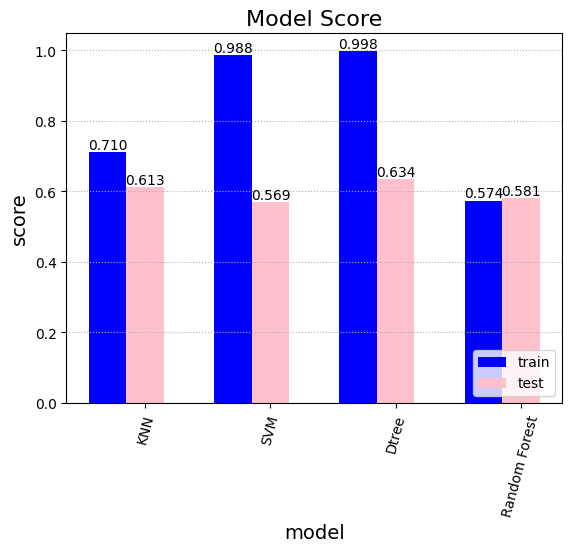

In [22]:
model_name = ["KNN","SVM","Dtree","Random Forest"]
import matplotlib.pyplot as plt
plt.title('Model Score', fontsize=16)
plt.xlabel('model', fontsize=14)
plt.ylabel('score', fontsize=14)
plt.grid(linestyle=':', axis='y')
x = np.arange(4)
a = plt.bar(x - 0.3, trainscores, 0.3, color='blue', label='train', align='center')
b = plt.bar(x, testscores, 0.3, color='pink', label='test', align='center')
# Set up labels
for i in a + b:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width() / 2, h, '%.3f' % h, ha='center', va='bottom')
plt.xticks(x,model_name,rotation=75)
plt.legend(loc='lower right')
plt.show()

In [23]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [25]:
import numpy as np
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, normalize
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from scipy.signal import welch
from scipy.integrate import simps
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.optimizers import Adam

def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    data = x.load()
    return data

files = []
for n in range(1, 33):
    s = f"{n:02d}"
    files.append(s)

labels = []
data = []
for i in files:
    fileph = "data_preprocessed_python/s" + i + ".dat"
    d = read_data(fileph)
    labels.append(d['labels'])
    data.append(d['data'])
labels = np.array(labels).reshape(1280, 4)
data = np.array(data).reshape(1280, 40, 8064)
eeg_data = data[:,:32,:]
def bandpower(data, sf, band):
    band = np.asarray(band)
    low, high = band
    nperseg = (2 / low) * sf
    freqs, psd = welch(data, sf, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = simps(psd[idx_band], dx=freq_res)
    return bp

def get_band_power(people, channel, band):
    bd = {"delta": (0.5, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 64)}
    return bandpower(eeg_data[people, channel], 128, bd[band])
eeg_band = []
for i in range(len(eeg_data)):
    for j in range(len(eeg_data[0])):
        eeg_band.append([get_band_power(i, j, b) for b in ["delta", "theta", "alpha", "beta", "gamma"]])
eeg_band = np.array(eeg_band).reshape((1280, 160))
labels_arousal = (labels[:, 1] > 5).astype(int)
X = eeg_band
y = labels_arousal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model
def build_bilstm(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model
X_train_lstm = X_train.reshape((X_train.shape[0], 32, 5))  # 32 channels, 5 bands
X_test_lstm = X_test.reshape((X_test.shape[0], 32, 5))
lstm_model = build_lstm((32, 5))
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=64, verbose=1)
lstm_train_score = lstm_model.evaluate(X_train_lstm, y_train)[1]
lstm_test_score = lstm_model.evaluate(X_test_lstm, y_test)[1]

/var/folders/4v/m7_zmbx51q1821mk6jcl41v40000gn/T/ipykernel_85381/187358374.py:46: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  bp = simps(psd[idx_band], dx=freq_res)


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5506 - loss: 0.6914
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5968 - loss: 0.6817
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5655 - loss: 0.6843
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5756 - loss: 0.6820
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5811 - loss: 0.6814
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5677 - loss: 0.6818
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5838 - loss: 0.6785
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5826 - loss: 0.6766
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5761 - loss: 0.6791
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5645 - loss: 0.6838
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5751 - loss: 0.6782 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5621 - loss: 0.6885



Classification Report for KNN:

              precision    recall  f1-score   support

           0       0.55      0.50      0.52       131
           1       0.67      0.71      0.69       189

    accuracy                           0.62       320
   macro avg       0.61      0.61      0.61       320
weighted avg       0.62      0.62      0.62       320


Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       131
           1       0.59      1.00      0.74       189

    accuracy                           0.59       320
   macro avg       0.30      0.50      0.37       320
weighted avg       0.35      0.59      0.44       320


Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.46      0.47      0.46       131
           1       0.63      0.62      0.63       189

    accuracy                           0.56       320
   macro avg       

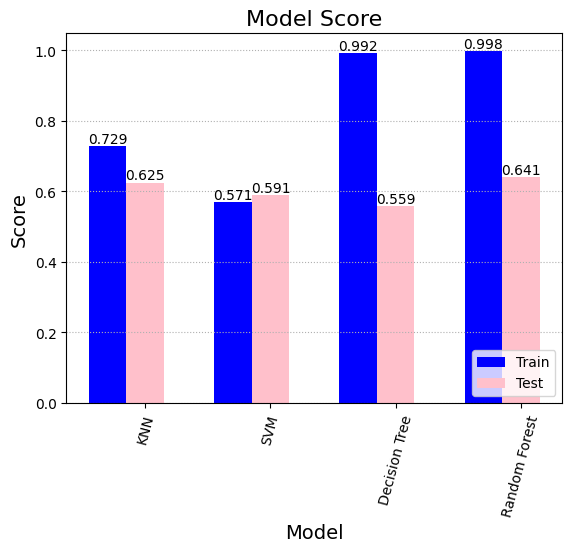

In [27]:
import pickle
import numpy as np
import pandas as pd
import math
from scipy.signal import butter, lfilter, welch
from scipy.integrate import simps
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report  # Importing classification_report
import matplotlib.pyplot as plt

# Assuming all previous code (data reading, processing, feature extraction) is present here...

# Prepare data_x and label_y
data_x = eeg_band
label_y = labels_arousal

# Preprocess Data
min_max_scaler = preprocessing.MinMaxScaler()
data_x = min_max_scaler.fit_transform(data_x)

# Apply PCA
pca = PCA(n_components=100)
data_x = pca.fit_transform(data_x)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(data_x, label_y)

# List to store train and test scores
trainscores = []
testscores = []

# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    # Predictions for classification report
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Append scores to lists
    trainscores.append(train_score)
    testscores.append(test_score)

# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=7)
train_and_evaluate_model(knn, X_train, y_train, X_test, y_test, "KNN")

# SVM Classifier
svc = SVC(kernel='rbf', C=0.1)
train_and_evaluate_model(svc, X_train, y_train, X_test, y_test, "SVM")

# Decision Tree Classifier
dtree = DecisionTreeClassifier(max_depth=20, min_samples_split=4)
train_and_evaluate_model(dtree, X_train, y_train, X_test, y_test, "Decision Tree")

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_split=5)
train_and_evaluate_model(rf, X_train, y_train, X_test, y_test, "Random Forest")


# Plot Results
model_name = ["KNN", "SVM", "Decision Tree", "Random Forest"]

plt.title('Model Score', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.grid(linestyle=':', axis='y')
x = np.arange(len(model_name))

# Bar plot for training and testing scores
a = plt.bar(x - 0.3, trainscores, 0.3, color='blue', label='Train', align='center')
b = plt.bar(x, testscores, 0.3, color='pink', label='Test', align='center')

# Set up labels
for i in a + b:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width() / 2, h, '%.3f' % h, ha='center', va='bottom')

plt.xticks(x, model_name, rotation=75)
plt.legend(loc='lower right')
plt.show()
